# Exercise 2: Exploring Galaxy Colors & Mass in the Local Universe

Compare the stellar mass estimates from the ATLAS3D modeled masses and computed using the Bell et al. (2003) mass-color relation.

STEPS

- Read tables:
  - ATLAS3D sample: ATLAS3D_initialsample_withmasses.csv
  - ATLAS3D sample with SDSS photometry: ATLAS3D_master_photometry.csv
  
- Visualize the location of the ATLAS3D galaxies:  
  - see http://balbuceosastropy.blogspot.com/2013/09/the-mollweide-projection.html

- Correct the magnitudes for Galactic extinction:
  - Galactic dust extinction: https://irsa.ipac.caltech.edu/applications/DUST/
  - IRSA Dust Extinction Service Queries: https://astroquery.readthedocs.io/en/latest/irsa/irsa_dust.html
  - from astroquery.irsa_dust import IrsaDust
    - Define coordinates to query: 
    - coo = SkyCoord(ra=ATLAS3d_phot.RA[i]*u.degree, dec=ATLAS3d_phot.DEC[i]*u.degree)
  - Query first table: table=IrsaDust.get_extinction_table(coo)
    - Rlambda = table['A_over_E_B_V_SandF'].data
    - gmask = (filters == 'SDSS g')
    - Rg = Rlambda[gmask] 
  - Query second table: table2=IrsaDust.get_query_table(coo, section='ebv')
    - EBV = table2['ext SFD ref']
    - Av = 3.1*EBV
    - Ag = Rg*Av/3.1

- Apply the K-correction to their magnitudes:
  - see http://kcor.sai.msu.ru/getthecode/#python

- Estimate stellar masses from Bell et al. 2003 and Taylor et al. 2011 mass-color relations:
  - see Bell et al. 2003, Appendix Table 7: http://iopscience.iop.org/article/10.1086/378847/pdf
    - use the (g-i) color and i-band absolute magnitude (same as Taylor et al. 2011)
  - see Taylor et al. 2011, Equation 8; http://adsabs.harvard.edu/abs/2011MNRAS.418.1587T

- Compare histogram of stellar masses derived from Bell et al. 2003, Taylor et al. 2011 and dynamical masses given in table (in solar masses, not logged)

In [1]:
from __future__ import division
import numpy as np
from astropy.io import ascii
import matplotlib.pyplot as plt
import ephem#to make coordinate systems conversions
from IPython.core.display import HTML#To include images as HTML
from astroquery.irsa_dust import IrsaDust
from astropy.coordinates import SkyCoord
from astropy import units as u
import calc_kcor as kcor#http://kcor.sai.msu.ru/getthecode/#python

In [2]:
#import tables
data_mass = ascii.read("ATLAS3D_initialsample_withmasses.csv")
data_photo = ascii.read("ATLAS3D_master_photometry.csv")

In [3]:
#Definition of Mollweide plot
def plot_mwd2(RA,Dec,RA2,Dec2,org=0,title='Mollweide projection', projection='mollweide'):
    x = np.remainder(RA+360-org,360) # shift RA values
    x2 = np.remainder(RA2+360-org,360)
    ind = x>180
    ind2 = x2>180
    x[ind] -=360    # scale conversion to [-180, 180]
    x2[ind2] -=360
    x=-x    # reverse the scale: East to the left
    x2 =-x2
    tick_labels = np.array([150, 120, 90, 60, 30, 0, 330, 300, 270, 240, 210])
    tick_labels = np.remainder(tick_labels+360+org,360)
    fig = plt.figure(figsize=(10, 5))
    ax = fig.add_subplot(111, projection=projection)#, axisbg ='LightCyan')
    ax.scatter(np.radians(x),np.radians(Dec), c="k")  # convert degrees to radians
    ax.scatter(np.radians(x2),np.radians(Dec2), c="b")
    ax.set_xticklabels(tick_labels)     # we add the scale on the x axis
    ax.set_title(title)
    ax.title.set_fontsize(15)
    ax.set_xlabel("RA")
    ax.xaxis.label.set_fontsize(12)
    ax.set_ylabel("Dec")
    ax.yaxis.label.set_fontsize(12)
    ax.grid(True)

## Visualize the location of the ATLAS3D galaxies

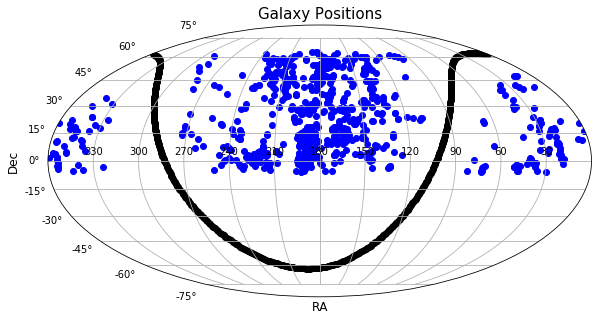

In [4]:
#Plot galaxy positions and galactic plane
lon_array = np.arange(0,360)
lat = 0.
eq_array = np.zeros((360,2))
for lon in lon_array:
    ga = ephem.Galactic(np.radians(lon), np.radians(lat))
    eq = ephem.Equatorial(ga)
    eq_array[lon] = np.degrees(eq.get())
RA = eq_array[:,0]
Dec = eq_array[:,1]

RA2 = []
Dec2=[]
for lon in range(len(data_mass)):
    RA2 += [data_mass[lon][1]]
    Dec2 += [data_mass[lon][2]]
RA2 = np.array(RA2)
Dec2 = np.array(Dec2)

plot_mwd2(RA, Dec, RA2, Dec2,180, title = 'Galaxy Positions')


## Correct the magnitudes for Galactic extinction

In [5]:
mag_g_correction=np.zeros(len(data_photo))
mag_g_correction[:]= -999.99
mag_i_correction=np.zeros(len(data_photo))
mag_i_correction[:]= -999.99

for i in range(len(data_photo)):
    coo = SkyCoord(ra=data_photo["RA"][i]*u.degree, dec=data_photo["DEC"][i]*u.degree)
    table=IrsaDust.get_extinction_table(coo)
    filters = table["Filter_name"].data
    Rv = table["A_over_E_B_V_SandF"].data
    gRvmask = (filters == "SDSS g")
    iRvmask = (filters == "SDSS i")
    gRv = Rv[gRvmask]
    iRv = Rv[iRvmask]
    
    table2 = IrsaDust.get_query_table(coo, section="ebv")
    EBV = table2["ext SFD ref"]
    mag_g_correction[i] = gRv*EBV
    mag_i_correction[i]= iRv*EBV 

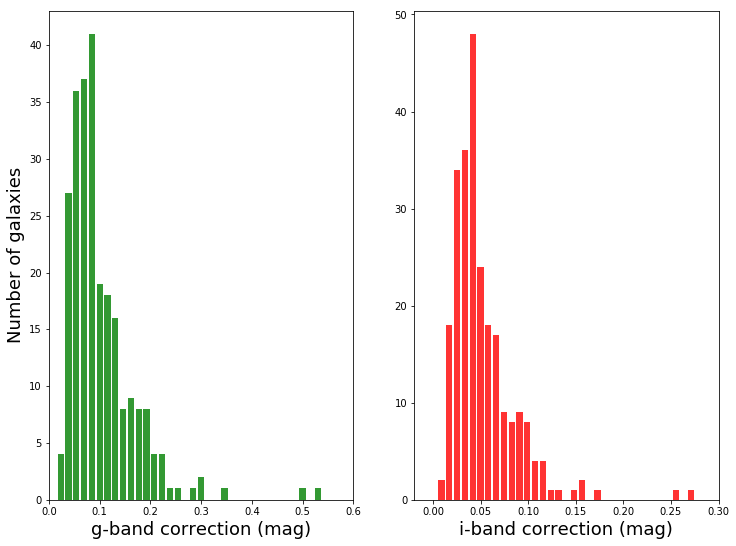

In [6]:
fig, ax = plt.subplots(1,2, figsize=(12,9))
bins0 = np.linspace(0.,0.6,40)
bins1 = np.linspace(-0.02,0.3,40)
ax[0].hist(mag_g_correction, bins0, histtype = "bar", alpha = 0.8, linewidth=1, color="green", rwidth=0.8)
ax[0].set_xlim([0.,0.6])
ax[0].set_xlabel("g-band correction (mag)", fontsize=18)
ax[0].set_ylabel("Number of galaxies", fontsize=18)
ax[1].hist(mag_i_correction, bins1, histtype = "bar", alpha = 0.8, linewidth=1, color="red", rwidth=0.8)
ax[1].set_xlim([-0.02,0.3])
ax[1].set_xlabel("i-band correction (mag)", fontsize=18)
plt.show;

## Apply the K-correction to the magnitudes

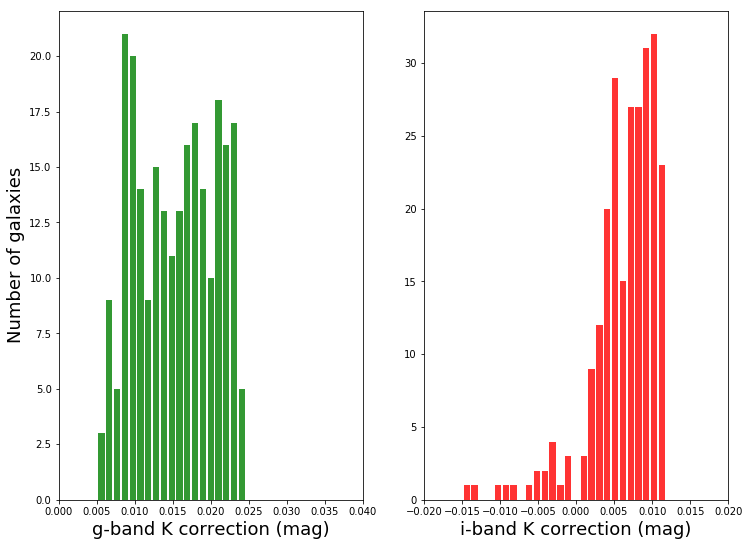

In [7]:
#kcor.calc_kcor(filter_name, redshift, colour_name, colour_value)
#data_photo["D"] distances in Mpc; Hubble constant H = 70
#z = D*H/c
g_kcorr = np.zeros(len(data_photo))
g_kcorr[:] = -999.99
i_kcorr = np.zeros(len(data_photo))
i_kcorr[:] = -999.99

for i in range(len(data_photo)):
    g_kcorr[i] = kcor.calc_kcor("g", data_photo["D"][i]*70./299792.458, "g - i", data_photo["fiberMag_g"][i]-data_photo["fiberMag_i"][i])
    i_kcorr[i] = kcor.calc_kcor("i", data_photo["D"][i]*70./299792.458, "g - i", data_photo["fiberMag_g"][i]-data_photo["fiberMag_i"][i])

fig, ax = plt.subplots(1,2, figsize=(12,9))
bins0 = np.linspace(0.,0.04,40)
bins1 = np.linspace(-0.02,0.02,40)
ax[0].hist(g_kcorr, bins0, histtype = "bar", alpha = 0.8, linewidth=1, color="green", rwidth=0.8)
ax[0].set_xlim([0.,0.04])
ax[0].set_xlabel("g-band K correction (mag)", fontsize=18)
ax[0].set_ylabel("Number of galaxies", fontsize=18)
ax[1].hist(i_kcorr, bins1, histtype = "bar", alpha = 0.8, linewidth=1, color="red", rwidth=0.8)
ax[1].set_xlim([-0.02,0.02])
ax[1].set_xlabel("i-band K correction (mag)", fontsize=18)
plt.show;


## Compare histogram of stellar masses derived from Bell et al. 2003, Taylor et al. 2011 and dynamical masses

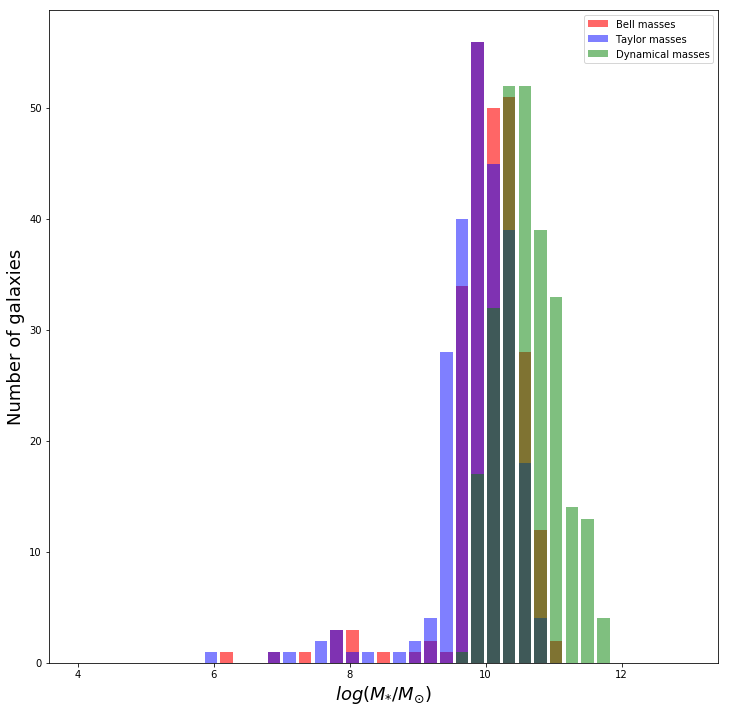

In [8]:
#taylor LogM/M_sun = 1.15 + 0.7 * (g-i) - 0.4* Mag_i
#bell LogM/M_sun = 0.518 * (g-i) - 0.152 + (Mag_i_sun - Mag_i)/2.5
colors_g_i = data_photo["fiberMag_g"]-data_photo["fiberMag_i"]
colors_g_i_corr = colors_g_i - (mag_g_correction-mag_i_correction) + (g_kcorr-i_kcorr)
#Absolute magnitude i-band
abs_mag_i = data_photo["petroMag_i"] - mag_i_correction + i_kcorr -5.0*np.log10(data_photo["D"])-25

taylor = 1.15 + 0.7*(colors_g_i_corr) - 0.4*abs_mag_i
#4.19 = absolute magnitude of sun in i-band (Mag_i_sun)
bell = 0.518*(colors_g_i_corr)-0.152 + (4.19- abs_mag_i)/2.5

stellar_mass = data_mass["StellarMass"].data
mass_mask = (stellar_mass != -999.99)
stellar_mass = np.log10(stellar_mass[mass_mask])
mass_mask = (stellar_mass != 0.)
stellar_mass = stellar_mass[mass_mask]


fig,ax = plt.subplots(figsize=(12,12))
bins = np.linspace(4,13,40)
ax.hist(bell, bins, histtype="bar", alpha = 0.6, linewidth = 1, rwidth = 0.8, label="Bell masses", color="red")
ax.hist(taylor, bins, histtype="bar", alpha = 0.5, linewidth = 1, rwidth = 0.8, label="Taylor masses", color="blue")
ax.hist(stellar_mass, bins, histtype="bar", alpha = 0.5, linewidth = 1, rwidth = 0.8, label="Dynamical masses", color="green")
ax.legend(prop={'size': 10});
ax.set_xlabel("$log(M_{*} / M_{\odot}$)", fontsize=18)
ax.set_ylabel("Number of galaxies", fontsize=18)
plt.show;
